In [1]:
import geojson
from tqdm import tqdm
import rasterio.features
import numpy as np
from shapely.geometry import MultiPolygon
import shapely
import matplotlib.pyplot as plt
import rasterio

In [2]:
%%time
path_to_file = './naturtyper_layer.geojson'

with open(path_to_file, 'r') as f:
    gj = geojson.load(f)
print(len(gj['features']), gj.keys())

312325 dict_keys(['type', 'name', 'crs', 'features'])
CPU times: user 1min 1s, sys: 3.09 s, total: 1min 5s
Wall time: 1min 5s


In [3]:
path = './ortodata_2014_res_2_crop.tif'
# Open the tif file 
tif_file = rasterio.open(path)
print(tif_file.shape)
print(tif_file.crs)

(135000, 85000)
EPSG:25832


In [4]:
gj_features = []
for feature in tqdm(gj['features']):
    if feature['properties']['Natyp_kode'] == 6: # Code for lakes is 6
        gj_features.append(feature)
print(len(gj_features))
gj_features[0]

100%|██████████████████████████████████████████████████████████████████████| 312325/312325 [00:00<00:00, 1007806.35it/s]

152920


{"geometry": {"coordinates": [[[[501332.248, 6224773.935], [501334.244, 6224779.934], [501334.244, 6224784.933], [501333.246, 6224790.932], [501327.243, 6224789.932], [501317.249, 6224783.933], [501316.243, 6224780.934], [501319.244, 6224774.935], [501324.25, 6224771.936], [501329.247, 6224770.936], [501332.248, 6224773.935]]]], "type": "MultiPolygon"}, "properties": {"Aendr_kode": 0, "Aendrbegr": "Ikke udfyldt", "Besig_dato": null, "Bruger_id": "00000000-0000-0000-0000-000000000000", "CVR_kode": 29189919, "CVR_navn": "Herning kommune", "Gl_sys_ref": null, "Journalnr": null, "Link": null, "Natyp_kode": 6, "Natyp_navn": "Sø", "Objekt_id": "0460cd7c-5353-11e2-af2b-00155d01e765", "Off_kode": 1, "Offentlig": "Synlig for alle", "Oprettet": "2006-12-31T01:00:00", "Oprindelse": "Ikke udfyldt", "Oprindkode": 0, "Sagsbeh": null, "Shape_area": 252.94599999301087, "Shape_length": 0.0, "Status": "Gældende / Vedtaget", "Statuskode": 3, "Systid_fra": "2006-12-31T01:00:00", "Systid_til": null, "Temak

0it [00:00, ?it/s]

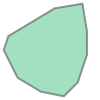

mask shape: (10, 9)


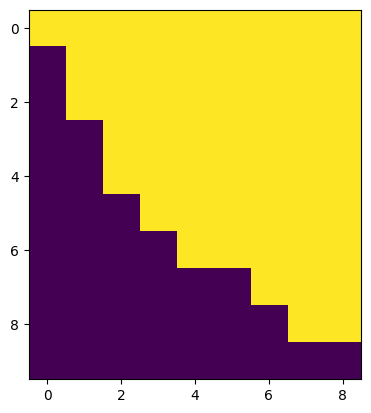

152920it [02:08, 1185.85it/s]

Failed to convert 3925 annotations


In [5]:
dataset = []
failed = 0

# Loop over the annotations
for i, feature in tqdm(enumerate(gj_features)):
    geometry = feature['geometry']
    coords = geometry['coordinates']
    coords_np = np.array(coords[0][0])

    try:
        poly = MultiPolygon(coords)
        # min_x, min_y, max_x, max_y = [np.round(c) for c in poly.bounds] # min x, min y, max x, max y
        # x, y = max_x - min_x, max_y - min_y # get width and height
    
        # Get the coordinates of the lake in the form [(x1, y1), (x2, y2), ...]
        coords_xy = np.array(coords).reshape(-1, 2)#.astype(int)
        
        # Split x and y coordinates
        x, y = coords_xy[:, 0], coords_xy[:, 1]
        
        # Get the minimum and maximum bounds of the lake
        x_min, x_max = np.min(x), np.max(x)
        y_min, y_max = np.min(y), np.max(y)
    
        # The data consist of an array which has some defined bounds
        # We now retrieve the index of our x and ys in relation to those bounds
        x_min_idx, y_min_idx = tif_file.index(x_min, y_min)
        x_max_idx, y_max_idx = tif_file.index(x_max, y_max)
    
        # Compute width and height
        w = abs(x_max_idx - x_min_idx)
        h = abs(y_max_idx - y_min_idx)
    
        # Re-center coordinates at (0,0)
        poly = shapely.transform(poly, lambda c: np.round(c - [x_min, y_min]))
        mask = rasterio.features.rasterize([poly], out_shape=(w, h))
        mask = np.flip(mask, 0)
    
        # Store in dictionary format for easy access
        data = {'geometry': geometry, 'coordinates': coords[0][0], 'mask': mask.tolist()}
        dataset.append(data)
        
        if i == 0:
            display(poly)
            print('mask shape:', mask.shape)
            plt.imshow(mask)
            plt.show()
            
    except: # Skip any polygons which can't be parsed
        failed += 1
        continue
print(f'Failed to convert {failed} annotations')

In [6]:
# print(poly.bounds)
# print(coords[0][0])
# print(x, y)
# lake_coords = np.array(coords).reshape(-1, 2)#.astype(int)
# x_, y_ = np.round(lake_coords[:, 0]), np.round(lake_coords[:, 1])
# x_min_, x_max_ = np.min(x_), np.max(x_)
# y_min_, y_max_ = np.min(y_), np.max(y_)
# print(x_max_ - x_min_, y_max_ - y_min_)

In [7]:
%%time
import json
with open('denmark_annotations.json', 'w') as f:
    json.dump(dataset, f)

CPU times: user 2min 53s, sys: 1.68 s, total: 2min 54s
Wall time: 2min 55s


In [10]:
arr = np.array([[1,1,1], [1,1,1], [1,1,1], [1,1,1]])
arr_2 = np.pad(arr, ((1, 2), (3, 4)), 'constant', constant_values=0)
print(arr_2)
print(arr.shape)
print(arr_2.shape)

[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 1 1 0 0 0 0]
 [0 0 0 1 1 1 0 0 0 0]
 [0 0 0 1 1 1 0 0 0 0]
 [0 0 0 1 1 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
(4, 3)
(7, 10)
